# HQoS Analysis

1. **Load helper functions** – These functions will be required in the subsequent code snippets.  
2. **PRIO-based queueing theory** – Apply priority-based queueing models to the problem.  
3. **Analytical vs. simulation comparison** – Validate analytical results against simulation outcomes for an isolated node.  
4. **Device configuration studies**:  
   4.1. Increase network interface capacity to accommodate additional background traffic (keeping O-FH dimensioning fixed).  
   4.2. Keep network interface capacity and maximum O-FH load fixed, while varying different traffic loads.  
5. **O-RU configuration analysis** – Explore scenarios considering subcarrier spacing (SCS), bandwidth, compression schemes, and spatial stream multiplexing.  
6. **Application of PRIO-based queueing theory to multiple scenarios**:  
   6.1. Theoretical exploration by varying combinations of traffic flows and loads.  
   6.2. Validation and extraction of additional statistics through network simulation at selected points of interest.


### 1. **Load helper functions**
Functions to obtain queueing metrics

In [6]:
# Function to calculate average packet size
def calculate_average_packet_size(packet_sizes):
    return sum(packet_sizes) / len(packet_sizes)

# Function to calculate E[Ts] given the average packet size and MidLinkCap
def calculate_E_Ts(avg_packet_size, mid_link_cap):
    return (avg_packet_size * 8) / mid_link_cap

def calculate_arrival_rate(Ratenum, avg_packet_size):
    return Ratenum / (avg_packet_size*8)



def calculateQueueingTimes(data, E_Ts_values, arrival_values, sigma_values):
    Tq_values = [[] for _ in range(2)] 
    for i, sigma_scen in enumerate(sigma_values):
        for k, sigma in enumerate(sigma_scen):
            if k == 0:
                Tq = (1 /2* ( sum( np.multiply( sum( np.multiply(arrival_values[i], arrival_values[i]/sum(arrival_values[i]))) , sum(np.multiply( arrival_values[i]/np.sum(arrival_values[i]),
                        ([ETs_i**2 for ETs_i in E_Ts])))) for i, E_Ts in enumerate(E_Ts_values[i])))) / ((1 - sigma))*1e6
            else:
                Tq = (1 /2* ( sum( np.multiply( sum( np.multiply(arrival_values[i], arrival_values[i]/sum(arrival_values[i]))) ,sum(np.multiply( arrival_values[i]/np.sum(arrival_values[i]),
                        ([ETs_i**2 for ETs_i in E_Ts])))) for i, E_Ts in enumerate(E_Ts_values[i]))))  / ((1 - sigma_values[i][k-1]) * (1 - sigma))*1e6
            Tq_values[k].append(Tq) ## Each group of flows
    return Tq_values




def SortTsTimes(data, E_Ts_values):
    E_Ts_values_plot = [[] for _ in range(len(data["RTFeatures"]))]

    E_Ts_values_plot[0] += [E_Ts_values[j][0] * 1e6 for j in range(len(E_Ts_values))]
    E_Ts_values_plot[1] += [E_Ts_values[j][1] * 1e6 for j in range(len(E_Ts_values))]
    # E_Ts_values_plot[2] += [E_Ts_values[j][1] * 1e6 for j in range(len(E_Ts_values))]
    return E_Ts_values_plot






def calculateQueueingTimes(E_Ts_values, arrival_values, sigma_values):
    Tq_values = [[] for _ in range(Priolevels)] 
    for i, sigma_scen in enumerate(sigma_values):
        for k, sigma in enumerate(sigma_scen):
            if k == 0:
                Tq = (1 / 2 * (sum(np.multiply(sum(arrival_values[i]), sum(np.multiply(arrival_values[i] / np.sum(arrival_values[i]), ([ETs_i**2 for ETs_i in E_Ts])))) 
                                  for i, E_Ts in enumerate(E_Ts_values[i]))))  / ((1 - sigma)) * 1e6
            else:
                Tq = (1 / 2 * (sum(np.multiply(sum(arrival_values[i]), sum(np.multiply(arrival_values[i] / np.sum(arrival_values[i]), ([ETs_i**2 for ETs_i in E_Ts])))) 
                                  for i, E_Ts in enumerate(E_Ts_values[i]))))  / ((1 - sigma_values[i][k-1]) * (1 - sigma)) * 1e6
            Tq_values[k].append(Tq) ## Each group of flows
    return Tq_values

### 2. **PRIO-based queueing theory**
Theoretical model

Number of priority levels:  2


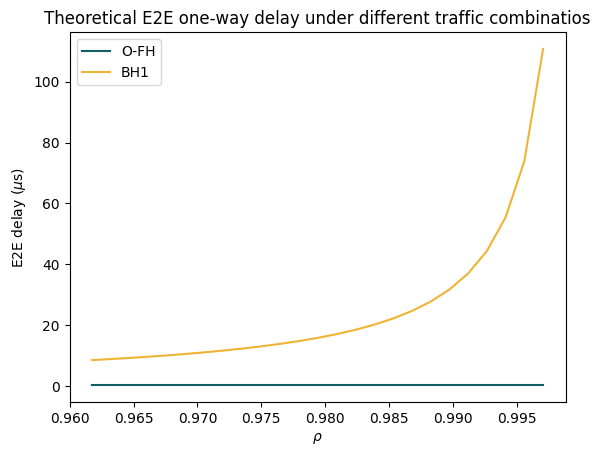

In [6]:

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from cycler import cycler
import seaborn as sns
servicelabels = ["O-FH", "BH1", "BH2", "BH3"]

servicecolors = ["#115e67", "#f0b434", "#ff5733", "#800000"]
# Guardar los colores como un cycler global
plt.rcParams['axes.prop_cycle'] = cycler(color=servicecolors)



# Constants
resultFoldername = "hl3hl5"
Foldername = f"./{resultFoldername}-{8000}spFHWRR2"
C = 1700e9
Source = 70e9
Nsources = 23 
Lambda2 = np.arange(25, 87.5, 2.5)
PacketSize = [[7680], [160,1358,1450]]
Trafficload = [[100], [23,26,51]]
Priolevels = len(PacketSize)
mapping = [1, 3]

print("Number of priority levels: ", Priolevels)

# Initialize variables
stats = []
Delayperflow = []

# Load JSON Data
jsonData = open("../scratch/hl3-hl5-23.json").read()
data = json.loads(jsonData)






E_Ts_Values = []
Utilization = []
Arrival_values = []
ETs = [[] for _ in range(Priolevels)]

for i, lambda2 in enumerate(Lambda2):
    E_Ts_aux = [[] for _ in range(Priolevels)]
    arrival_values = [[] for _ in range(Priolevels)]
    utilization = []

    for i, coef_i in enumerate(Trafficload):
        for j, coef_j in enumerate(coef_i):
            if (i == 0) and (j == 0):
                arrival_values[i].append((Source*Nsources*coef_j/100) / (PacketSize[i][j] * 8))  # Arrival rate λ
                E_Ts_aux[i].append((PacketSize[i][j] * 8) / C)  # Calculate E[Ts] based on average packet size and mid_link_cap values
            else:    
                arrival_values[i].append(((lambda2 * 1e9) * (coef_j / 100)) / (PacketSize[i][j] * 8))  # Arrival rate λ
                E_Ts_aux[i].append((PacketSize[i][j] * 8) / C)  # Calculate E[Ts] based on average packet size and mid_link_cap values

    
    for i in range(Priolevels):
        Avg_L = np.sum((arrival_values[i] / np.sum(arrival_values[i])) * PacketSize[i])
        # print(f"Average L: {Avg_L}")
        utilization.append(np.sum(arrival_values[i]) * ((Avg_L * 8) / C))
        # print(np.sum(arrival_values[i]) * ((Avg_L * 8) / C))
        ETs[i].append(((Avg_L * 8) / C) * 1e6)
    
    # print(f" Utilization {utilization}")
    Utilization.append(utilization)
    E_Ts_Values.append(E_Ts_aux) ## Obtain E[Ts] values for each flow in order to obtain the Tq values  
    Arrival_values.append(arrival_values)
    if np.sum(utilization) >= 1:
        print("Max value with Lambda 2: ", lambda2)
        break
    



sigma_values = np.cumsum(Utilization,axis=1)
# print("Utilization: ", Utilization)
# print("Sigma: ", sigma_values)
Tq_values = calculateQueueingTimes(E_Ts_Values, arrival_values, sigma_values)
Tt = []
for i, Tq in enumerate(Tq_values):
    Tt.append(np.add(Tq, ETs[i]))
    plt.plot(list(np.sum(Utilization, axis=1)), Tt[-1], label=servicelabels[i])

plt.title("Theoretical E2E one-way delay under different traffic combinatios")    
plt.xlabel(r"$\rho$")
plt.ylabel(r"E2E delay ($\mu$s)")
plt.legend()
# Create a dictionary to hold the data
data = {
    'TrafficLoadFH': list(np.sum(Utilization, axis=1))
}

# Add Tt values to the dictionary
for level in range(Priolevels):
    data[f'Tt_{servicelabels[level]}'] = Tt[level]

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# # Save the DataFrame to a CSV file
# df.to_csv(f"./theoretical_values_Tt_Utilization.csv", sep='\t', index=False)

# print("Theoretical values Tt and Utilization saved to './theoretical_values_Tt_Utilization.csv'")


# # Prepare data for TikZ export
# datatikz = {
#     'Utilization': list(np.sum(Utilization, axis=1))
# }

# Loop over priority levels to extract and store data
# for level in range(Priolevels):
#     print(f"Processing level {level}: {servicelabels[level]}")
    
#     # Extract data for current queue level
#     queue_data = AvgE2E_df[AvgE2E_df['queue'] == level]
    
#     if not queue_data.empty:
#         datatikz[f'Tt_{servicelabels[level]}'] = Tt[level]
#         datatikz[f'AvgE2E_{servicelabels[level]}'] = queue_data['mean'].values
#         datatikz[f'AvgE2E_25_{servicelabels[level]}'] = queue_data['p25'].values
#         datatikz[f'AvgE2E_75_{servicelabels[level]}'] = queue_data['p75'].values
#     else:
#         print(f"Warning: No data for queue {level}")

# # Convert the TikZ data dictionary to a DataFrame and save as .dat
# df2 = pd.DataFrame(datatikz)
# df2.to_csv(f"./{Priolevels}LEVELSdelay_sim.dat", sep='\t', index=False)
# print(f"Simulation data saved to './{Priolevels}LEVELSdelay_sim.dat'")

### 3. **Analytical vs. simulation comparison**

Number of priority levels: 2
[processing - data] ...
>> Reading Results File From Gobal BH Traffic = 25
>> Reading Results File From Gobal BH Traffic = 30
>> Reading Results File From Gobal BH Traffic = 35
>> Reading Results File From Gobal BH Traffic = 40
>> Reading Results File From Gobal BH Traffic = 45
>> Reading Results File From Gobal BH Traffic = 50
>> Reading Results File From Gobal BH Traffic = 55
>> Reading Results File From Gobal BH Traffic = 60
>> Reading Results File From Gobal BH Traffic = 65
>> Reading Results File From Gobal BH Traffic = 70
>> Reading Results File From Gobal BH Traffic = 75
>> Reading Results File From Gobal BH Traffic = 80
--- Data Successfully Processd ! ---
DataFrame guardado en './AvgE2E_delay_percentiles.csv'


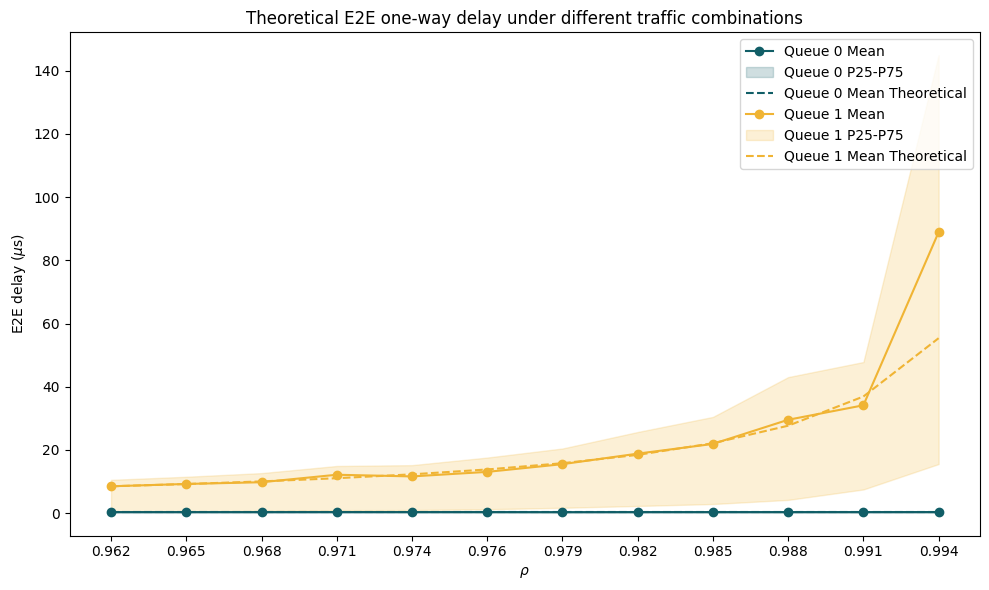

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from cycler import cycler

# Configuración colores (asumiendo servicecolors está definido antes)
plt.rcParams['axes.prop_cycle'] = cycler(color=servicecolors)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Lista de colores en el orden del ciclo

# Parámetros y constantes
nrowslim = True
nrowsnum = 100000
resultFoldername = "hl3hl5"
Foldername = f"{resultFoldername}-8000sp"
C = 1700e9
Source = 70e9
Nsources = 23
Lambda2 = np.arange(25, 85, 5)
PacketSize = [[7680], [160, 1358, 1450]]
Trafficload = [[100], [23, 26, 51]]
Priolevels = len(PacketSize)

print("Number of priority levels:", Priolevels)

# Variables auxiliares
stats = []
mapping = [1, 3]

# Cargar datos JSON
with open("../scratch/hl3-hl5-1.json") as f:
    data = json.load(f)

print("[processing - data] ...")
# Procesar datos para cada lambda2
for lambda2 in Lambda2:
    print(">> Reading Result Files From Global BH Traffic =", lambda2)    
    e2e_delays = []
    Delayperflow = []

    # Procesar Hl5Aggregation
    for flow in range(len(data["Hl5Agreggration"])):
        file_suffix = f"{Foldername}{lambda2:.1f}"
        nrows_param = None if not nrowslim else nrowsnum
        
        Tx1 = pd.read_csv(f"../sim_results/{file_suffix}/TxFileSite1Sector{flow}.log",
                          sep=r'\s+', header=None, names=["pkid", "Time", "Value"],
                          engine='python', nrows=nrows_param, skipfooter=1 if not nrowslim else 0)
        Rx1 = pd.read_csv(f"../sim_results/{file_suffix}/RxFileSite1User{flow}.log",
                          sep=r'\s+', header=None, names=["pkid", "Time", "Value"],
                          engine='python', nrows=nrows_param, skipfooter=1 if not nrowslim else 0)
        
        minlen = min(len(Tx1), len(Rx1))
        e2e_delays.append(Rx1["Time"][:minlen] - Tx1["Time"][:minlen])
    
    Delayperflow.append(np.concatenate(e2e_delays))

    # Procesar BHFeatures
    for flow in range(len(data["BHFeatures"])):
        file_suffix = f"{Foldername}{lambda2:.1f}"
        nrows_param = None if not nrowslim else nrowsnum

        Tx1 = pd.read_csv(f"../sim_results/{file_suffix}/BH1TxFile{flow}.log",
                          sep=r'\s+', header=None, names=["pkid", "Time", "Value"],
                          engine='python', nrows=nrows_param, skipfooter=1 if not nrowslim else 0)
        Rx1 = pd.read_csv(f"../sim_results/{file_suffix}/RxFileBH1_{flow}.log",
                          sep=r'\s+', header=None, names=["pkid", "Time", "Value"],
                          engine='python', nrows=nrows_param, skipfooter=1 if not nrowslim else 0)

        minlen = min(len(Tx1), len(Rx1))
        e2eflow = Rx1["Time"][:minlen] - Tx1["Time"][:minlen]
        Delayperflow.append(e2eflow)

    # Calcular estadísticas por cola
    ind1 = 0
    for index, i in enumerate(mapping):
        ind2 = ind1 + (i - 1)
        if i > 1:
            concatenated_array = np.concatenate(Delayperflow[ind1:ind2+1])
        else:
            concatenated_array = Delayperflow[ind1]

        # Estadísticas (convertir a segundos)
        mean_value = np.mean(concatenated_array * 1e-9)
        percentiles = np.percentile(concatenated_array * 1e-9, [5, 25, 50, 75, 95])

        stats.append({
            'queue': index,
            'lambda': lambda2,
            'mean': mean_value,
            'p5': percentiles[0],
            'p25': percentiles[1],
            'p50': percentiles[2],
            'p75': percentiles[3],
            'p95': percentiles[4]
        })

        ind1 += i 

print("--- Data Successfully Processd ! ---")
# Convertir a DataFrame y guardar CSV
AvgE2E_df = pd.DataFrame(stats)
AvgE2E_df.to_csv("./AvgE2E_delay_percentiles.csv", sep='\t', index=False)
print("DataFrame guardado en './AvgE2E_delay_percentiles.csv'")

# Extraer colas únicas
queues = AvgE2E_df['queue'].unique()

# Inicializar Tt para teóricos si no está definido antes
Tt = []

# Graficar resultados
plt.figure(figsize=(10, 6))

for i, (queue, Tq) in enumerate(zip(queues, Tq_values)):
    queue_data = AvgE2E_df[AvgE2E_df['queue'] == queue]

    color = colors[i % len(colors)]  # Para reciclar colores si hay más queues que colores

    # Curva real
    plt.plot(queue_data['lambda'], queue_data['mean'], label=f'Queue {queue} Mean', marker='o', color=color)
    plt.fill_between(queue_data['lambda'], queue_data['p25'], queue_data['p75'], alpha=0.2, color=color, label=f'Queue {queue} P25-P75')

    # Curva teórica
    Tt.append(np.add(Tq, ETs[i]))
    plt.plot(queue_data['lambda'], Tt[-1], label=f"Queue {queue} Mean Theoretical", linestyle='dashed', color=color)

# Ajustar etiquetas del eje x con utilización
tick_positions = queue_data['lambda'].values
tick_labels = [f"{rho:.3f}" for rho in np.sum(Utilization, axis=1)]

plt.xticks(tick_positions, tick_labels)
plt.xlabel(r"$\rho$")
plt.ylabel(r"E2E delay ($\mu$s)")
plt.title("Theoretical E2E one-way delay under different traffic combinations")
plt.legend()
plt.tight_layout()
plt.show()


### 4. **Device configuration studies**


#### 4.1. Increase network interface capacity to accommodate additional background traffic (keeping O-FH dimensioning fixed).  

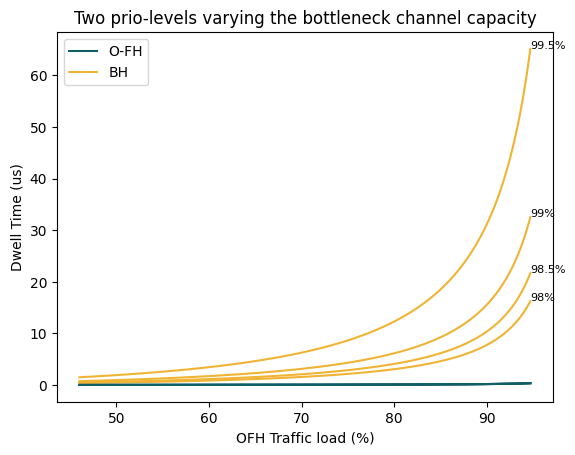

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns

resultFoldername = "hl3hl5"
path = f"../sim_results/hl3hl5/{resultFoldername}/"



rhoswept = [98, 98.5 ,99, 99.5]
Source = 70e9
Nsources = 23 
PktSource1 = 7680
TotSources = Nsources*Source
Lambda1Tot = TotSources/(PktSource1 *8)
servicelabels = ["O-FH", "BH"]
servicecolors = ["#115e67", "#f0b434"]
Bottleneck = np.arange(1700, 3500, 1)
   
## Traffic mix of second level of priorization
Coef = [23, 26, 51]
PacketSize2 = [160, 1358, 1450]

def calculateQueueingTimes(E_Ts_values, arrival_values, sigma_values):
    Tq_values = [[] for _ in range(2)] 
    for i, sigma_scen in enumerate(sigma_values):
        for k, sigma in enumerate(sigma_scen):
            if k == 0:
                Tq = (1 /2* ( sum( np.multiply( sum( arrival_values[i]) , sum(np.multiply( arrival_values[i]/np.sum(arrival_values[i]), ([ETs_i**2 for ETs_i in E_Ts])))) 
                                  for i, E_Ts in enumerate(E_Ts_values[i]))))  / ((1 - sigma))*1e6
            else:
                Tq = (1 /2* ( sum( np.multiply( sum( arrival_values[i]) , sum(np.multiply( arrival_values[i]/np.sum(arrival_values[i]), ([ETs_i**2 for ETs_i in E_Ts])))) 
                                  for i, E_Ts in enumerate(E_Ts_values[i]))))  / ((1 - sigma_values[i][k-1]) * (1 - sigma))*1e6
            Tq_values[k].append(Tq) ## Each group of flows
    return Tq_values


E_Ts_values = []
E_Ts_Values = []
E_Ts = []
utilization = []
Tq_values = []
sigma = []
Arrival_values = []
arrival_values = []



Utilization = []
RTArrivalRate = []
bhrates = []

ETs = [[] for _ in range(2)]




for idx, Rho in enumerate(rhoswept):
    E_Ts_values = []
    E_Ts_Values = []
    E_Ts = []
    utilization = []
    Tq_values = []
    sigma = []
    Arrival_values = []
    arrival_values = []
    
    
    Utilization = []
    RTArrivalRate = []
    bhrates = []

    ETs = [[] for _ in range(Priolevels)]
    for i, C in enumerate(Bottleneck):
        C = C*1e9
        lambda2 = C*(Rho/100) - TotSources
        # print(f"BH traffic {lambda2/1e9} Gbps")
        E_Ts_aux = []
        E_Ts = []
        utilization = []
        bhrates = []

        for index, coef_i in enumerate(Coef):
            bhrates.append(((lambda2)*(coef_i/100)) / (PacketSize2[index]*8))  # Arrival rate λ
        # print(bhrates)
        arrival_values.append([Lambda1Tot])
        arrival_values.append(list(bhrates))
        E_Ts_aux.append([PktSource1*8/(C)])
        utilization.append(Lambda1Tot * (( PktSource1*8)/(C)))

        
        ETs[0].append(((PktSource1*8)/(C))*1e6)
        ## For BH
        for index, _ in enumerate(PacketSize2):
            E_Ts.append(calculate_E_Ts(PacketSize2[index], C) )  # Calculate E[Ts] based on average packet size and mid_link_cap values
        # RTArrivalRate = ((arrival_value/np.sum(arrival_value))*arrival_value) # Arrival rate λi, i = 1, 2, 3
        Avg_L = np.sum((bhrates/np.sum(bhrates))*PacketSize2)
        utilization.append(np.sum(bhrates)*(Avg_L*8/(C))) # λT * E[Ts]

        if np.sum(utilization) >= 1:
            print("Max value")
            break
        E_Ts_aux.append(E_Ts)
        E_Ts_Values.append(E_Ts_aux) ## Obtain E[Ts] values for each flow in orde to obatin the Tq values
        ETs[1].append((Avg_L*8/(C))*1e6)


        Utilization.append(utilization)
        

        
    # print(f"Utilization {Utilization}")   

    sigma_values = np.cumsum(Utilization,axis=1)




    # print(arrival_values)
    Tq_values = calculateQueueingTimes(E_Ts_Values, arrival_values, sigma_values)
    # print("E_Ts Values: ", ETs)
    # print(f"Waiting Time (Tq) Values: {Tq_values} us")
    swept = True
    Tt_values = []
    for i, Tq in enumerate(Tq_values):
        Tt = np.add(Tq, ETs[i])
        Tt_values.append(Tt)
        # print(str(Tt))
        load = (1610/Bottleneck)*100
        if idx == 0:
            plt.plot(load, Tt, label=f"{servicelabels[i]}", color=servicecolors[i])
        else:
            plt.plot(load, Tt, color=servicecolors[i])
        # plt.text((1610/Bottleneck)*100, Tt[-1], f"{rhoswept[i]}%", fontsize=8)
                
        
        # print(f"Tq {i} {Tq}")
    # print("\n")
        
    plt.text((1610/Bottleneck[0])*100, Tt[0], f"{Rho}%", fontsize=8)       
            

    plt.title("Two prio-levels varying the bottleneck channel capacity")
    plt.ylabel("Dwell Time (us)")
    plt.xlabel(r'OFH Traffic load (%)')
    plt.legend(ncols=1)


    # np.savetxt(f"plot_data{Rho}.dat", np.column_stack((load, Tt_values[0], Tt_values[1])), delimiter=' ', header='Bottleneck Tt1 Tt2', comments='')

#### 4.2. Keep network interface capacity and maximum O-FH load fixed, while varying different traffic loads.  

Number of priority levels:  4


Text(0.5, 1.0, 'E2E one-way delay vs O-FH (%) Traffic Load ')

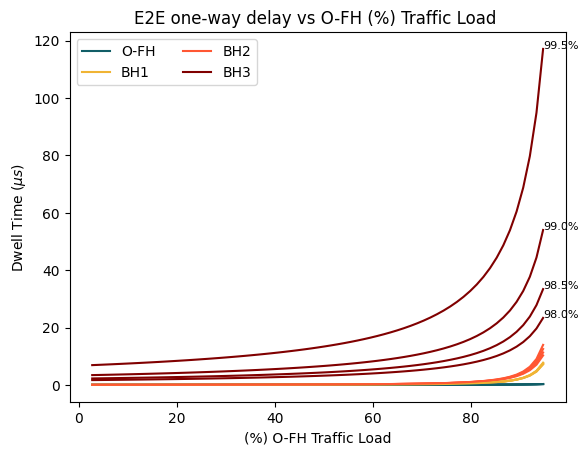

In [8]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
servicelabels = ["O-FH", "BH1", "BH2", "BH3"]
servicecolors = ["#115e67", "#f0b434", "#ff5733", "#800000"]

"""
This script calculates the queuing times for different priority levels in a network simulation.
"""
resultFoldername = "hl3hl5"
Foldername = f"../sim_results/{resultFoldername}-{8000}sp"

# Constants and parameters
Nsources = 23
C = 1700e9
Satmin, Satmax, Satstep = 98, 99.5, 0.5
OFHTFmin, OFHTFmax, OFHTFstep = 2, 70, 1
swept = True
# Configuration of traffic combinations - maximum for prio levels 
PacketSize = [[7680], [160], [1358], [1450]]
Trafficload = [[100], [23], [26], [51]]


### 


Sources = np.arange(OFHTFmin, OFHTFmax+OFHTFstep, OFHTFstep)*1e9
Satper = np.arange(Satmin, Satmax+Satstep, Satstep)


Priolevels = len(PacketSize)
arrival_values = [[] for _ in range(Priolevels)]
print("Number of priority levels: ", Priolevels)






for plotnum, satlevel in enumerate(Satper):
    E_Ts_Values = []
    Utilization = []
    Arrival_values = []
    ETs = [[] for _ in range(Priolevels)]

    for i, Source in enumerate(Sources):

        E_Ts_aux = [[] for _ in range(Priolevels)]
        arrival_values = [[] for _ in range(Priolevels)]
        utilization = []
        for i, coef_i in enumerate(Trafficload):
            for j, coef_j in enumerate(coef_i):
                if (i == 0) and (j == 0):
                    arrival_values[i].append((Source*Nsources*coef_j/100) / (PacketSize[i][j] * 8))  # Arrival rate λ
                    E_Ts_aux[i].append((PacketSize[i][j] * 8) / C)  # Calculate E[Ts] based on average packet size and mid_link_cap values
                else:    
                    # print(f"Remaing Rate: {(C-Source*Nsources)*1e-9}")
                    if (swept == True):
                        
                        remaining_rate = (((C*(satlevel/100))-Source*Nsources)) * (coef_j / 100)
                    else: 
                        remaining_rate = 85e9 * (coef_j / 100)
                    arrival_values[i].append((remaining_rate) / (PacketSize[i][j] * 8))  # Arrival rate λ
                    E_Ts_aux[i].append((PacketSize[i][j] * 8) / C)  # Calculate E[Ts] based on average packet size and mid_link_cap values

        
        for i in range(Priolevels):
            Avg_L = np.sum((arrival_values[i] / np.sum(arrival_values[i])) * PacketSize[i])
            # print(f"Average L: {Avg_L}")
            utilization.append(np.sum(arrival_values[i]) * ((Avg_L * 8) / C))
            # print(np.sum(arrival_values[i]) * ((Avg_L * 8) / C))
            ETs[i].append(((Avg_L * 8) / C) * 1e6)
        
      
        Utilization.append(utilization)
        E_Ts_Values.append(E_Ts_aux) ## Obtain E[Ts] values for each flow in order to obtain the Tq values  
        Arrival_values.append(arrival_values)
        if np.sum(utilization) >= 1:
            print(f"Utilization {utilization}")
            print("Max value with Lambda 2: ", Source*1e-9)
            break
        


    # print(f"Utilization {np.sum(utilization)}")        
    sigma_values = np.cumsum(Utilization,axis=1)
    # print("Utilization: ", Utilization)
    # print("Sigma: ", sigma_values)
    Tq_values = calculateQueueingTimes(E_Ts_Values, arrival_values, sigma_values)
    # print("E_Ts Values: ", ETs)
    # print(f"Waiting Time (Tq) Values: {Tq_values} us")
    # plt.figure()
    Tt = []
    for flow_i, Tq in enumerate(Tq_values):
        Tt.append(np.add(Tq, ETs[i]))
        # plt.plot(list(np.sum(Utilization, axis=1)), Tt, label=servicelabels[i], color=servicecolors[i])
        if plotnum == 0:
            legend = servicelabels[flow_i]
        else:
            legend = ''
        # plt.semilogy(((23*Sources)/C)*100, Tt[flow_i], label=legend, color=servicecolors[flow_i])
        plt.plot(((23*Sources)/C)*100, Tt[flow_i], label=legend, color=servicecolors[flow_i])
       
    if swept == True:
        plt.text((23*Sources[-1]/C)*100, Tt[-1][-1], f"{satlevel}%", fontsize=8)    
    
    plt.ylabel(r"Dwell Time ($\mu s$)")
    plt.xlabel(r"(%) O-FH Traffic Load")
    plt.legend(ncols=2)
plt.title(f"E2E one-way delay vs O-FH (%) Traffic Load ")
    
    
    
## Save the data in .dat file in order to plot that in tikz
# data = {
#     'TrafficLoadFH': ((23*Sources)/C)*100
# }
# for level in range(Priolevels):
#     data[f'Tt_{servicelabels[level]}'] = Tt[level]
# df = pd.DataFrame(data)
# df.to_csv(f"./e2e_delay_vs_fh_{satlevel}.dat", sep='\t', index=False)
    


### 5. **O-RU configuration analysis**

Number of priority levels:  2
Invalid SCS and Bandwidth combination
Not available configuration BW: 5 MHz, SCS 60 kHz
Invalid SCS and Bandwidth combination
Not available configuration BW: 60 MHz, SCS 15 kHz
Invalid SCS and Bandwidth combination
Not available configuration BW: 70 MHz, SCS 15 kHz
Invalid SCS and Bandwidth combination
Not available configuration BW: 80 MHz, SCS 15 kHz
Invalid SCS and Bandwidth combination
Not available configuration BW: 90 MHz, SCS 15 kHz
Invalid SCS and Bandwidth combination
Not available configuration BW: 100 MHz, SCS 15 kHz


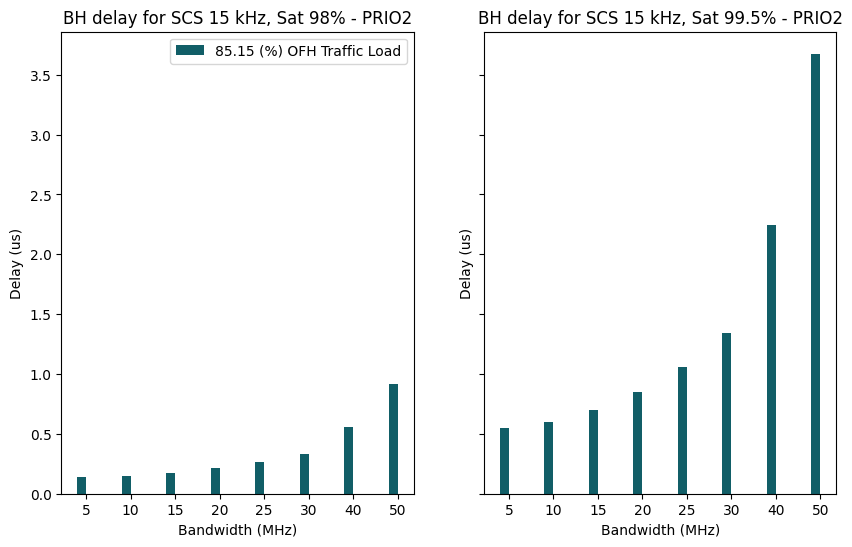

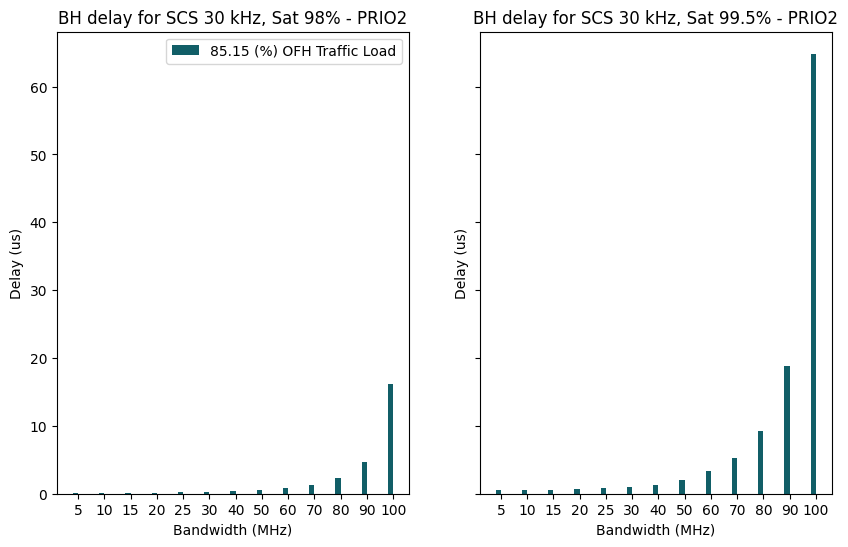

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


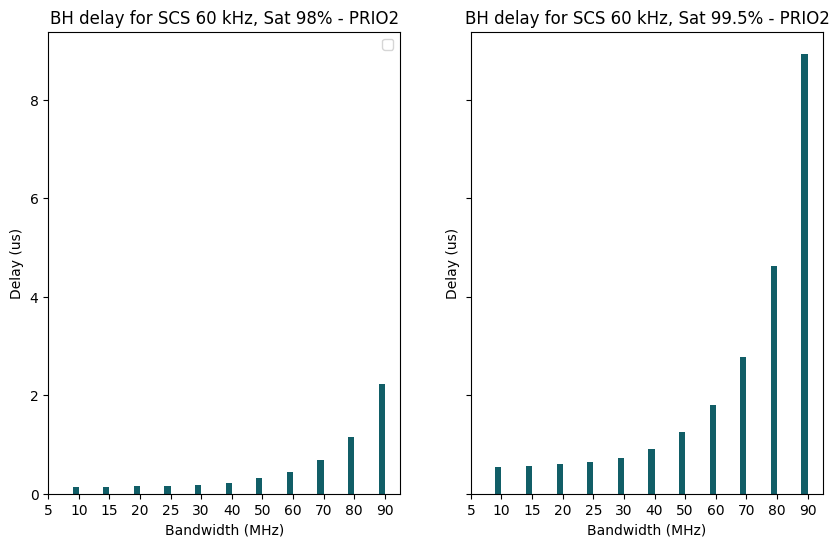

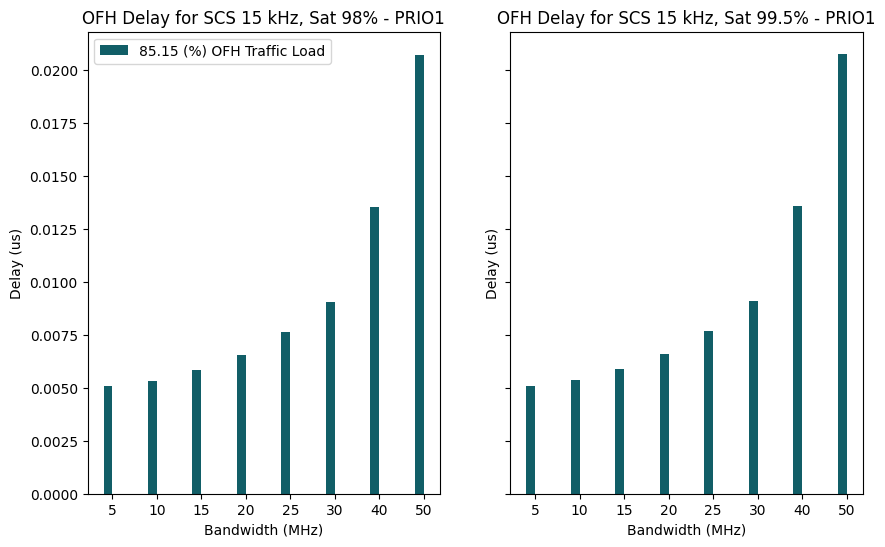

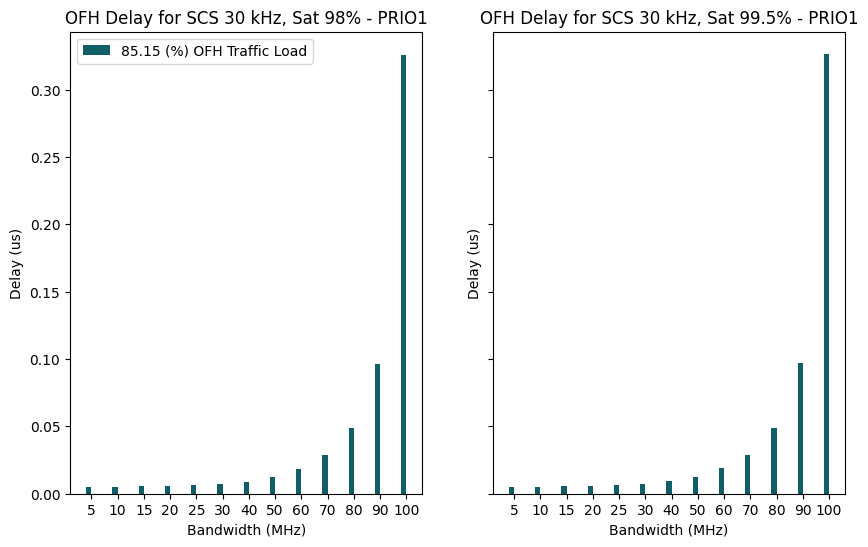

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


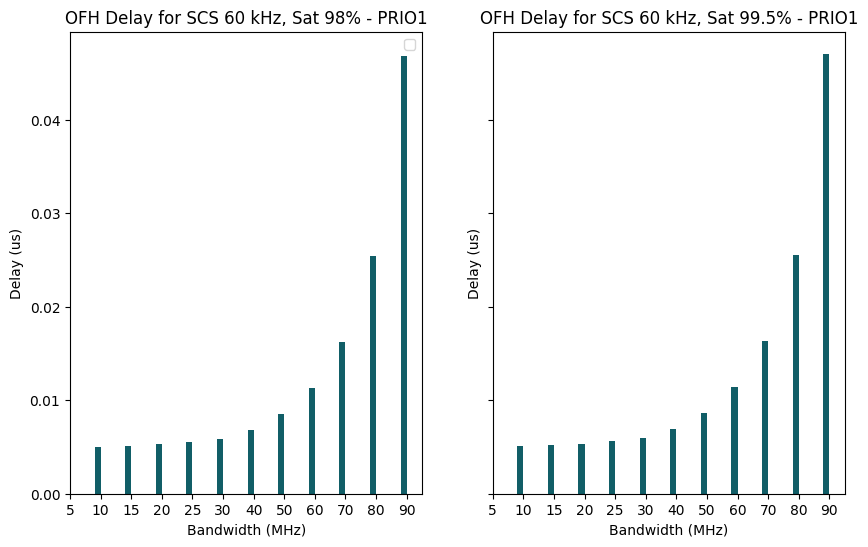

In [14]:
import matplotlib.pyplot as plt

import traffic_conf as tc

import itertools as it
import numpy as np
import pandas as pd
import pprint


Satper = [98, 99.5]
OFH_Site_Load = [85.15]
Nsources = 23 
C = 1700e9

swept = True

PacketSize = [[0], [160, 1358, 1450]]
Trafficload = [[100], [23, 26, 51]]




Priolevels = len(PacketSize)
arrival_values = [[] for _ in range(Priolevels)]

# TotSources = Nsources * Source
# Lambda1Tot = TotSources / (PktSource1 * 8)
servicelabels = ["O-FH", "BH1", "BH2", "BH3"]
servicecolors = ["#115e67", "#f0b434", "#ff5733", "#800000"]


print("Number of priority levels: ", Priolevels)
# Assuming the necessary variables are already defined as per the provided context

# Initialize a dictionary to store the data for plotting
plot_data = {}

for bw, scs in it.product(tc.bandwidth_values, tc.SCS_values):
    # print(f"SCS: {scs} kHz, Bandwidth: {bw} MHz")    
    result = tc.traffic_def_alldata(bw, scs, 1, 14, "BFP9", 16, 32)
    if result == None:
        print(f"Not available configuration BW: {bw} MHz, SCS {scs} kHz")
        continue
    
    user_pkt_size, user_rb, _, _ = result
    Sources = [3 * user_rb * 1e9 * (load / 100) for load in OFH_Site_Load]

    # print(f"User Packet Size: {user_pkt_size} bytes")
    PacketSize[0][0] = user_pkt_size + 36

    for plotnum, satlevel in enumerate(Satper):
        E_Ts_Values = []
        Utilization = []
        Arrival_values = []
        ETs = [[] for _ in range(Priolevels)]

        for i, Source in enumerate(Sources):
            E_Ts_aux = [[] for _ in range(Priolevels)]
            arrival_values = [[] for _ in range(Priolevels)]
            utilization = []
            for i, coef_i in enumerate(Trafficload):
                for j, coef_j in enumerate(coef_i):
                    if (i == 0) and (j == 0):
                        arrival_values[i].append((Source*Nsources*coef_j/100) / (PacketSize[i][j] * 8))  # Arrival rate λ
                        E_Ts_aux[i].append((PacketSize[i][j] * 8) / C)  # Calculate E[Ts] based on average packet size and mid_link_cap values
                    else:    
                        if (swept == True):
                            remaining_rate = (((C*(satlevel/100))-Source*Nsources)) * (coef_j / 100)
                        else: 
                            remaining_rate = 85e9 * (coef_j / 100)
                        arrival_values[i].append((remaining_rate) / (PacketSize[i][j] * 8))  # Arrival rate λ
                        E_Ts_aux[i].append((PacketSize[i][j] * 8) / C)  # Calculate E[Ts] based on average packet size and mid_link_cap values

            for i in range(Priolevels):
                Avg_L = np.sum((arrival_values[i] / np.sum(arrival_values[i])) * PacketSize[i])
                utilization.append(np.sum(arrival_values[i]) * ((Avg_L * 8) / C))
                ETs[i].append(((Avg_L * 8) / C) * 1e6)
       
            Utilization.append(utilization)
            E_Ts_Values.append(E_Ts_aux) ## Obtain E[Ts] values for each flow in order to obtain the Tq values  
            Arrival_values.append(arrival_values)
            if np.sum(utilization) >= 1:
                print(f"Utilization {utilization}")
                print("Max value with Lambda 2: ", Source*1e-9)
                break

        sigma_values = np.cumsum(Utilization, axis=1)
        Tq_values = calculateQueueingTimes(E_Ts_Values, arrival_values, sigma_values)
        Tt = []
        
        for flow_i, Tq in enumerate(Tq_values):
            Tt.append(np.add(Tq, ETs[i]))

        # Store the data for plotting
        if scs not in plot_data:
            plot_data[scs] = {}
        if bw not in plot_data[scs]:
            plot_data[scs][bw] = []
        plot_data[scs][bw].append((satlevel, Tt))
     
# Plotting the bar graph BH Delays
for scs in plot_data:
    num_sats = len(Satper)
    fig, axes = plt.subplots(1, num_sats, figsize=(5 * num_sats, 6), sharey=True)
    bar_width = 0.2
    index = np.arange(len(plot_data[scs]))
    for j, satlevel in enumerate(Satper):
        ax = axes[j]
        for i, bw in enumerate(tc.bandwidth_values):
            delays = [Tt[1] for sat, Tt in plot_data[scs][bw] if sat == satlevel] if bw in plot_data[scs] else []
            if delays:  # Check if delays is not empty
                for k, delay in enumerate(delays[0]):
                    if k < len(servicecolors) and i < len(index):  # Ensure k and i are within bounds
                        ax.bar(index[i] + k * bar_width, delay, bar_width, color=servicecolors[k], label=f'{OFH_Site_Load[k]} (%) OFH Traffic Load' if i == 0 else "")
        ax.set_xlabel('Bandwidth (MHz)')
        ax.set_ylabel('Delay (us)')
        ax.set_title(f'BH delay for SCS {scs} kHz, Sat {satlevel}% - PRIO2')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels([f'{bw}' for bw in tc.bandwidth_values[:len(index)]])
        if j == 0:
            ax.legend()
    plt.show()
# Print plot_data in a readable format
# Plotting the bar graph BH Delays
for scs in plot_data:
    num_sats = len(Satper)
    fig, axes = plt.subplots(1, num_sats, figsize=(5 * num_sats, 6), sharey=True)
    bar_width = 0.2
    index = np.arange(len(plot_data[scs]))
    for j, satlevel in enumerate(Satper):
        ax = axes[j]
        for i, bw in enumerate(tc.bandwidth_values):
            delays = [Tt[0] for sat, Tt in plot_data[scs][bw] if sat == satlevel] if bw in plot_data[scs] else []
            if delays:  # Check if delays is not empty
                for k, delay in enumerate(delays[0]):
                    if k < len(servicecolors) and i < len(index):  # Ensure k and i are within bounds
                        ax.bar(index[i] + k * bar_width, delay, bar_width, color=servicecolors[k], label=f'{OFH_Site_Load[k]} (%) OFH Traffic Load' if i == 0 else "")
        ax.set_xlabel('Bandwidth (MHz)')
        ax.set_ylabel('Delay (us)')
        ax.set_title(f'OFH Delay for SCS {scs} kHz, Sat {satlevel}% - PRIO1')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels([f'{bw}' for bw in tc.bandwidth_values[:len(index)]])
        if j == 0:
            ax.legend()
    plt.show()




# Print plot_data in a readable format
# print(plot_data)



# # Iterate through the plot_data to extract the second array for each combination
# for scs in plot_data:
#     # Initialize a dictionary to store the data for the DataFrame
#     df_data = {}
#     for bw in plot_data[scs]:
#         for satlevel, Tt in plot_data[scs][bw]:
#             if (bw) not in df_data:
#                 df_data[(bw)] = []
#             df_data[(bw)].append(Tt[1][0])

#     # Create a DataFrame from the dictionary
#     df = pd.DataFrame.from_dict(df_data, orient='index')

#     # Set the index names for better readability
#     df.index.names = ["Bandwidth"]

#     # Set the column names to Satlevel
#     df.columns = Satper

#     # Print the DataFrame
#     print(df)
#     df.to_csv(f"./results/e2eBH_delay_vs_fh_bw{bw}scs{scs}.dat", sep='\t', index=True)
    
    
#     # Iterate through the plot_data to extract the second array for each combination
# for scs in plot_data:
#     # Initialize a dictionary to store the data for the DataFrame
#     df_data = {}
#     for bw in plot_data[scs]:
#         for satlevel, Tt in plot_data[scs][bw]:
#             if (bw) not in df_data:
#                 df_data[(bw)] = []
#             df_data[(bw)].append(Tt[0][0])

#     # Create a DataFrame from the dictionary
#     df = pd.DataFrame.from_dict(df_data, orient='index')

#     # Set the index names for better readability
#     df.index.names = ["Bandwidth"]

#     # Set the column names to Satlevel
#     df.columns = Satper

#     # Print the DataFrame
#     print(df)
#     df.to_csv(f"./results/e2eFH_delay_vs_fh_bw{bw}scs{scs}.dat", sep='\t', index=True)

### 6. **Application of PRIO-based queueing theory to multiple cut-off points**

#### 6.1 Theoretical exploration by varying combinations of traffic flows and loads. 
**Make it with 4.2 code**
#### 6.2 Validation and extraction of additional statistics through network simulation at selected points of interest.

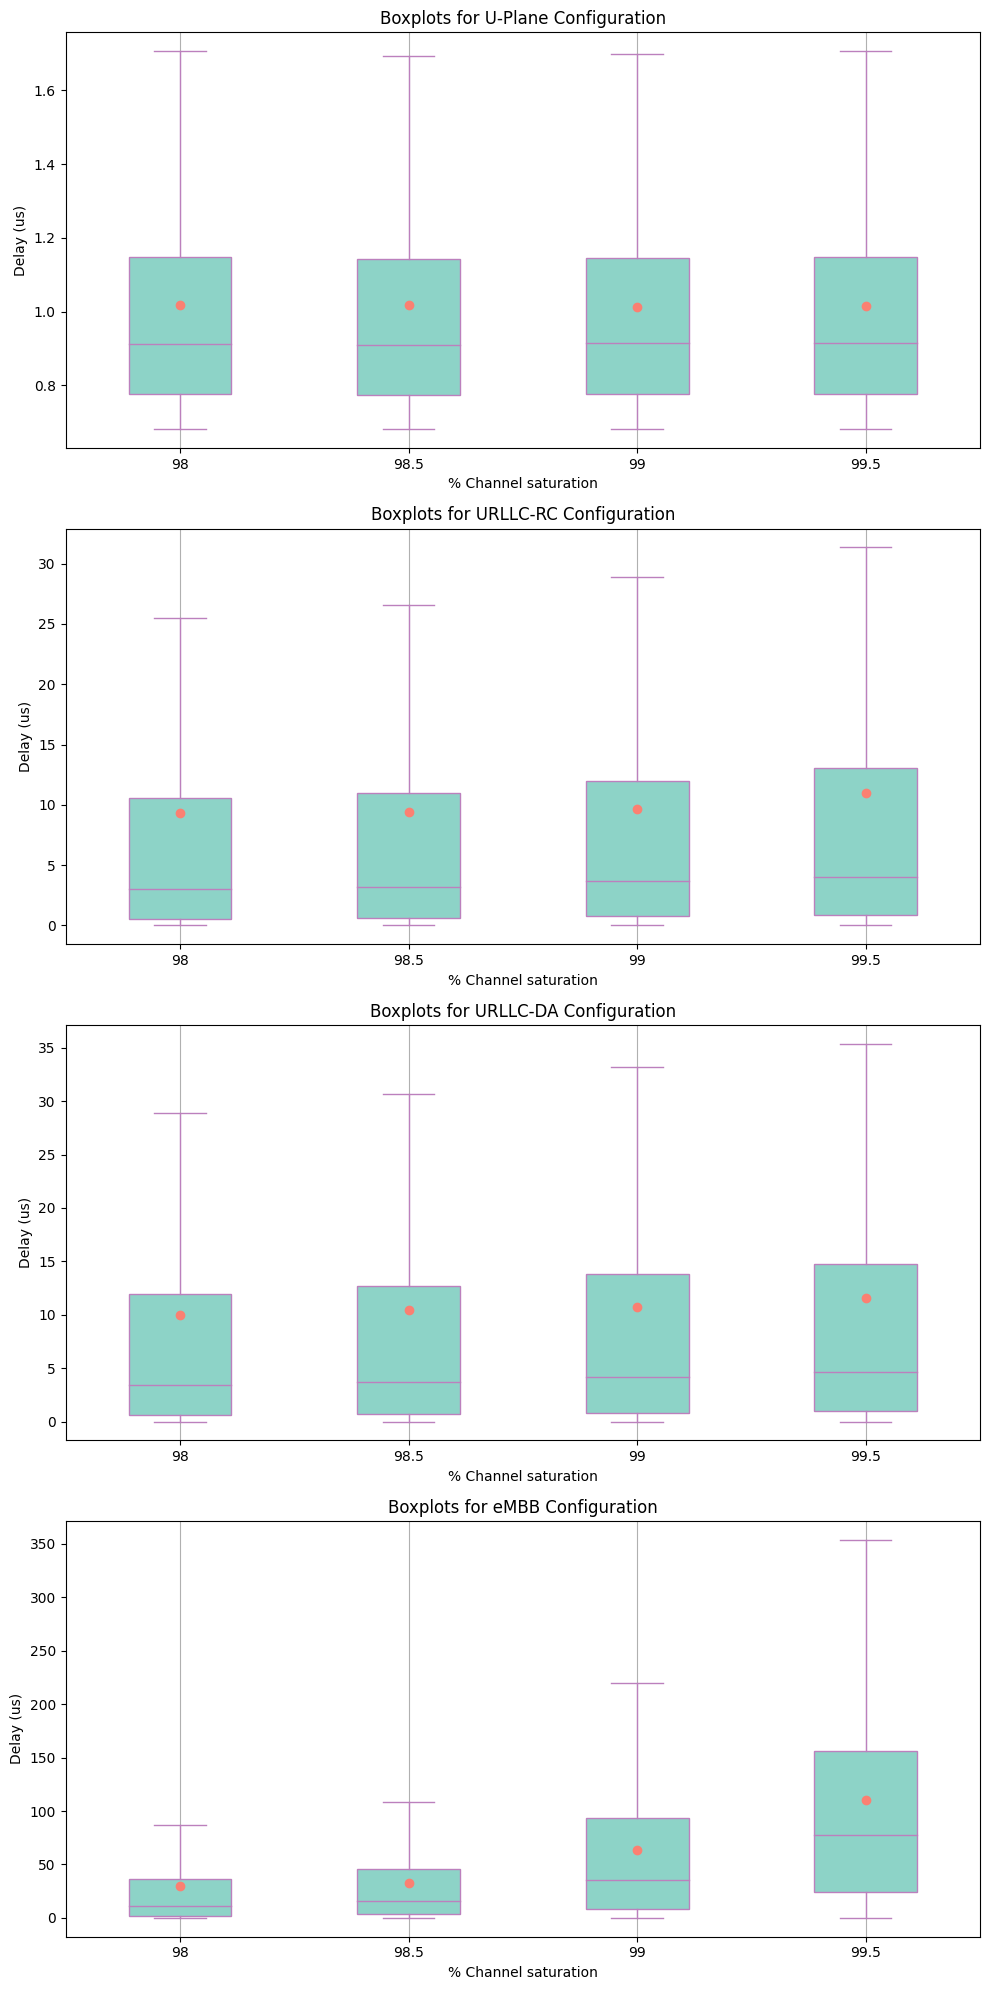

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

# Set a custom color palette
colors = plt.cm.Set3.colors

plt.rcParams["figure.autolayout"] = True

C = 1700e9
nnodes = 23
SiteLimit = 70e9
SatLevels = [98, 98.5, 99, 99.5]

BHswept = C*1e-9*(np.array(SatLevels)/100) - nnodes*SiteLimit*(1e-9)


Type_of_combis = [f"hl3hl5-8000spFHWRR3N{nnodes}C"]
folders = [f"../sim_results/{name_combi}{cap:.1f}/" for name_combi in Type_of_combis for cap in BHswept]








Flow_min_value = 1
Flow_max_value = 4
RU = nnodes
Step = 1
configs_txt = ["U-Plane", "URLLC-RC", "URLLC-DA", "eMBB"]
Flows = np.arange(1, Flow_max_value + Step, Step)
Ru = np.arange(0, RU, Step)
AAUs = np.arange(1, 2, 1)
Nsim = 1

def process_folder(folder):
    delay = []
    delay_aux = [] 
    delay_us = []
    delay_control = []
    delay_user = []
    delay_rt = []

    for flow in Flows:
        if flow == 1:
            for ru in Ru:
                # CTx = pd.read_csv(f"{folder}Site1TxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                UTx = pd.read_csv(f"{folder}TxFileSite1Sector{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                # CRx = pd.read_csv(f"{folder}Site1RxFileControl{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
                URx = pd.read_csv(f"{folder}RxFileSite1User{ru}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])

                min_len = min(len(UTx), len(URx))
                delay_user.append(URx["Time"].values[:min_len] - UTx["Time"].values[:min_len])
                # min_len = min(len(CTx), len(CRx))
                # delay_control.append(CRx["Time"].values[:min_len] - CTx["Time"].values[:min_len])

            delay.append(np.concatenate(delay_user))
            # delay.append(np.concatenate(delay_control))
        else: 
            delay_rt = []
         
            Tx = pd.read_csv(f"{folder}BH1TxFile{flow-2}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            Rx = pd.read_csv(f"{folder}RxFileBH1_{flow-2}.log", sep='\s+', header=None, names=["pkid", "Time", "Value"])
            min_len = min(len(Tx), len(Rx))
            delay_rt.append( Rx["Time"].values[:(min_len-1)] - Tx["Time"].values[:(min_len-1)])

            delay.append(np.concatenate(delay_rt))

    delay_us = [arr*1e-9 for arr in delay]    
    return delay_us






# Process data for each folder
delay_us_dict = {}
for folder in folders:
    delay_us_dict[folder] = process_folder(folder)


# Plot all boxplots in the same figure
fig, axes = plt.subplots(nrows=len(configs_txt), ncols=1, figsize=(10, 20))

for i, config in enumerate(configs_txt):
    ax = axes[i]
    # Collect delay data for this configuration label from all folders
   
    data = [delay_us_dict[folder][i] for folder in folders]
    # Plot boxplots for this configuration label
    bp = ax.boxplot(
        data,
        labels=SatLevels,
        showmeans=True,
        showfliers=False,
        patch_artist=True,  # fill with color
        boxprops=dict(facecolor=colors[0], color=colors[9]),
        capprops=dict(color=colors[9]),
        whiskerprops=dict(color=colors[9]),
        flierprops=dict(markeredgecolor=colors[9], markerfacecolor=colors[9]),
        medianprops=dict(color=colors[9]),
        meanprops=dict(marker="o", markerfacecolor=colors[3], markeredgecolor=colors[3]),
    )
    ax.set_title(f"Boxplots for {config} Configuration")
    
    ax.set_ylabel("Delay (us)")
    ax.set_xlabel("% Channel saturation")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.grid()

    # Extracting boxplot information
    lw = [item.get_ydata()[1] for item in bp['whiskers'][::2]]
    lq = [item.get_ydata()[0] for item in bp['whiskers'][::2]]
    med = [item.get_ydata()[1] for item in bp['medians']]
    uq = [item.get_ydata()[0] for item in bp['whiskers'][1::2]]
    uw = [item.get_ydata()[1] for item in bp['whiskers'][1::2]]
    xaux = range(len(folders))
    avg = [item.get_ydata()[0] for item in bp['means']]

    # Write to a text file
    with open(f"../sim_results/boxplot_coordinates_{config.replace(' ', '_')}.txt", "w") as f:
        f.write("bh\tlw\tlq\tmed\tuq\tuw\txaux\tavg\n")
        for bh_val, lw_val, lq_val, med_val, uq_val, uw_val, xaux_val, avg_val in zip(BHswept,lw, lq, med, uq, uw, xaux, avg):
            f.write(f"{bh_val}\t{lw_val}\t{lq_val}\t{med_val}\t{uq_val}\t{uw_val}\t{xaux_val}\t{avg_val}\n")
    
    # Save outliers to a text file
    for j, satlevel in enumerate(SatLevels):
        outliers = [item.get_ydata() for item in bp['fliers'][j::len(SatLevels)]]
        with open(f"../sim_results/outliers_{config.replace(' ', '_')}_folder_{j}.txt", "w") as f:
            f.write("Outliers\n")
            for outlier in outliers:
                for value in outlier:
                    f.write(f"{value}\n")
    
plt.tight_layout()
plt.show()



